In [10]:
# Importações necessárias
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

print("📚 Bibliotecas importadas com sucesso!")
print("🦇 Batman está preparado para o trading sistemático!")

📚 Bibliotecas importadas com sucesso!
🦇 Batman está preparado para o trading sistemático!


## 🎯 CONFIGURAÇÃO FLEXÍVEL DO SISTEMA

Sistema genérico que aceita qualquer ativo da B3. Basta alterar o `TICKER_SYMBOL` para usar com VALE3, BRFS3, etc.

In [11]:
# 🎮 CONFIGURAÇÃO PRINCIPAL - ALTERE AQUI PARA USAR OUTRO ATIVO
TICKER_SYMBOL = "PETR3.SA"  # Pode ser: PETR3.SA, VALE3.SA, BRFS3.SA, etc.
PERIOD = "1y"              # Período dos dados: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
INITIAL_CAPITAL = 10000.0   # Capital inicial em R$

# Parâmetros do Q-Learning (Abordagem Batman - Conservadora)
LEARNING_RATE = 0.1        # Taxa de aprendizado
DISCOUNT_FACTOR = 0.95     # Fator de desconto (gamma)
EPSILON_START = 1.0        # Exploração inicial
EPSILON_MIN = 0.01         # Exploração mínima  
EPSILON_DECAY = 0.995      # Decaimento da exploração
NUM_EPISODES = 1000        # Número de episódios de treinamento

# Estados discretos (Batman usa faixas simples)
NUM_PRICE_BINS = 10        # Número de faixas de preço
WINDOW_SIZE = 5            # Janela histórica

print(f"🎯 Configurado para: {TICKER_SYMBOL}")
print(f"💰 Capital inicial: R$ {INITIAL_CAPITAL:,.2f}")
print(f"📊 Período: {PERIOD}")
print(f"🧠 Episodes: {NUM_EPISODES}")

🎯 Configurado para: PETR3.SA
💰 Capital inicial: R$ 10,000.00
📊 Período: 1y
🧠 Episodes: 1000


## 📈 COLETA DE DADOS GENÉRICA

In [12]:
# 📊 Função genérica para carregar dados de qualquer ativo
def load_stock_data(ticker_symbol, period="1y"):
    """
    Carrega dados históricos de qualquer ativo da B3
    
    Args:
        ticker_symbol (str): Símbolo do ativo (ex: 'PETR3.SA', 'VALE3.SA')
        period (str): Período dos dados
    
    Returns:
        pd.DataFrame: Dados históricos do ativo
    """
    try:
        print(f"📡 Baixando dados de {ticker_symbol}...")
        ticker = yf.Ticker(ticker_symbol)
        
        # Buscar informações da empresa
        info = ticker.info
        company_name = info.get('longName', 'N/A')
        sector = info.get('sector', 'N/A')
        
        # Buscar dados históricos
        df = ticker.history(period=period)
        
        if df.empty:
            raise ValueError(f"Nenhum dado encontrado para {ticker_symbol}")
        
        print(f"✅ Dados carregados com sucesso!")
        print(f"   📊 Empresa: {company_name}")
        print(f"   🏢 Setor: {sector}")
        print(f"   📅 Período: {df.index[0].date()} até {df.index[-1].date()}")
        print(f"   📈 Total de dias: {len(df)}")
        print(f"   💰 Preço atual: R$ {df['Close'].iloc[-1]:.2f}")
        
        return df, info
        
    except Exception as e:
        print(f"❌ Erro ao carregar dados: {e}")
        return None, None

# Carregar dados do ativo configurado
df_stock, stock_info = load_stock_data(TICKER_SYMBOL, PERIOD)

📡 Baixando dados de PETR3.SA...
✅ Dados carregados com sucesso!
   📊 Empresa: Petróleo Brasileiro S.A. - Petrobras
   🏢 Setor: Energy
   📅 Período: 2024-10-24 até 2025-10-24
   📈 Total de dias: 250
   💰 Preço atual: R$ 31.75
✅ Dados carregados com sucesso!
   📊 Empresa: Petróleo Brasileiro S.A. - Petrobras
   🏢 Setor: Energy
   📅 Período: 2024-10-24 até 2025-10-24
   📈 Total de dias: 250
   💰 Preço atual: R$ 31.75


## 🧠 BATMAN Q-LEARNING SYSTEM

### Estados Discretos (Abordagem Conservadora)
Batman utiliza uma abordagem metodológica com estados discretizados para garantir convergência estável.

In [13]:
# 🎯 Sistema de Estados Discretos (Batman Approach)
class BatmanStateManager:
    def __init__(self, prices, num_bins=10, window_size=5):
        self.prices = prices
        self.num_bins = num_bins
        self.window_size = window_size
        
        # Criar faixas de preços (discretização)
        self.price_min = prices.min()
        self.price_max = prices.max()
        self.price_bins = np.linspace(self.price_min, self.price_max, num_bins + 1)
        
        print(f"🎯 Estados Batman configurados:")
        print(f"   📊 Faixas de preço: {num_bins} bins")
        print(f"   📈 Range: R$ {self.price_min:.2f} - R$ {self.price_max:.2f}")
        print(f"   🔍 Janela histórica: {window_size} dias")
        print(f"   🧮 Total de estados possíveis: {num_bins ** window_size:,}")
    
    def discretize_price(self, price):
        """Converte preço contínuo em faixa discreta"""
        return np.digitize(price, self.price_bins) - 1
    
    def get_state(self, current_index):
        """Cria estado discreto baseado em janela histórica"""
        if current_index < self.window_size:
            # Para os primeiros dias, usar o primeiro preço
            window_prices = [self.prices[0]] * (self.window_size - current_index - 1)
            window_prices.extend(self.prices[:current_index + 1])
        else:
            window_prices = self.prices[current_index - self.window_size + 1:current_index + 1]
        
        # Discretizar cada preço da janela
        discrete_state = tuple([self.discretize_price(price) for price in window_prices])
        return discrete_state

# Ações disponíveis (padrão do Prof. Paulo)
class Actions:
    HOLD = 0
    BUY = 1
    SELL = 2
    
    @classmethod
    def get_all_actions(cls):
        return [cls.HOLD, cls.BUY, cls.SELL]
    
    @classmethod 
    def action_name(cls, action):
        names = {cls.HOLD: "HOLD", cls.BUY: "BUY", cls.SELL: "SELL"}
        return names.get(action, "UNKNOWN")

# Preparar dados
if df_stock is not None:
    prices = df_stock['Close'].values
    state_manager = BatmanStateManager(prices, NUM_PRICE_BINS, WINDOW_SIZE)
    
    print(f"\n📋 Resumo dos dados:")
    print(f"   📊 Total de observações: {len(prices)}")
    print(f"   📈 Primeiro preço: R$ {prices[0]:.2f}")
    print(f"   📉 Último preço: R$ {prices[-1]:.2f}")
else:
    print("❌ Erro: Dados não carregados!")

🎯 Estados Batman configurados:
   📊 Faixas de preço: 10 bins
   📈 Range: R$ 30.26 - R$ 39.56
   🔍 Janela histórica: 5 dias
   🧮 Total de estados possíveis: 100,000

📋 Resumo dos dados:
   📊 Total de observações: 250
   📈 Primeiro preço: R$ 33.84
   📉 Último preço: R$ 31.75


## 🏛️ AMBIENTE DE TRADING BATMAN

Ambiente simples e confiável, seguindo princípios de metodologia Batman.

In [14]:
# 🏛️ Ambiente de Trading Batman (Estável e Metodológico)
class BatmanTradingEnvironment:
    def __init__(self, prices, state_manager, initial_capital=10000.0):
        self.prices = prices
        self.state_manager = state_manager
        self.initial_capital = initial_capital
        self.reset()
        
    def reset(self):
        """Reinicia o ambiente para novo episódio"""
        self.current_step = self.state_manager.window_size
        self.cash = self.initial_capital
        self.shares = 0
        self.portfolio_values = []
        self.actions_history = []
        self.episode_rewards = []
        
        return self.get_current_state()
    
    def get_current_state(self):
        """Retorna estado atual discretizado"""
        return self.state_manager.get_state(self.current_step)
    
    def get_portfolio_value(self):
        """Calcula valor total do portfólio"""
        current_price = self.prices[self.current_step]
        return self.cash + (self.shares * current_price)
    
    def step(self, action):
        """Executa uma ação e retorna (next_state, reward, done, info)"""
        current_price = self.prices[self.current_step]
        portfolio_value_before = self.get_portfolio_value()
        
        # Executar ação
        action_executed = False
        if action == Actions.BUY and self.cash >= current_price:
            # Comprar 1 ação
            self.shares += 1
            self.cash -= current_price
            action_executed = True
            
        elif action == Actions.SELL and self.shares > 0:
            # Vender 1 ação  
            self.shares -= 1
            self.cash += current_price
            action_executed = True
            
        # HOLD não executa nada, mas sempre é válido
        if action == Actions.HOLD:
            action_executed = True
        
        # Calcular recompensa (Batman usa mudança simples no portfólio)
        portfolio_value_after = self.get_portfolio_value()
        reward = portfolio_value_after - portfolio_value_before
        
        # Registrar histórico
        self.portfolio_values.append(portfolio_value_after)
        self.actions_history.append(action)
        self.episode_rewards.append(reward)
        
        # Avançar para próximo dia
        self.current_step += 1
        done = self.current_step >= len(self.prices) - 1
        
        # Próximo estado (ou None se terminado)
        next_state = self.get_current_state() if not done else None
        
        # Informações adicionais
        info = {
            'cash': self.cash,
            'shares': self.shares, 
            'portfolio_value': portfolio_value_after,
            'current_price': current_price,
            'action_executed': action_executed,
            'day': self.current_step
        }
        
        return next_state, reward, done, info
    
    def get_episode_summary(self):
        """Retorna resumo do episódio atual"""
        if not self.portfolio_values:
            return None
            
        total_return = (self.get_portfolio_value() - self.initial_capital) / self.initial_capital
        max_value = max(self.portfolio_values)
        min_value = min(self.portfolio_values) 
        
        return {
            'total_return': total_return,
            'final_value': self.get_portfolio_value(),
            'max_value': max_value,
            'min_value': min_value,
            'total_reward': sum(self.episode_rewards),
            'num_days': len(self.portfolio_values),
            'actions_taken': len([a for a in self.actions_history if a != Actions.HOLD])
        }

# Inicializar ambiente Batman
if df_stock is not None:
    env = BatmanTradingEnvironment(prices, state_manager, INITIAL_CAPITAL)
    print("🏛️ Ambiente Batman inicializado com sucesso!")
    print(f"   💰 Capital inicial: R$ {INITIAL_CAPITAL:,.2f}")
    print(f"   📊 Dados disponíveis: {len(prices)} dias")
    print(f"   🎯 Início do trading no dia {env.current_step}")
else:
    print("❌ Erro: Ambiente não pode ser inicializado!")

🏛️ Ambiente Batman inicializado com sucesso!
   💰 Capital inicial: R$ 10,000.00
   📊 Dados disponíveis: 250 dias
   🎯 Início do trading no dia 5


## 🦇 AGENTE Q-LEARNING BATMAN

Implementação clássica do Q-Learning seguindo os padrões das aulas do Prof. Paulo Caixeta.

In [15]:
# 🦇 Agente Q-Learning Batman (Clássico e Confiável)
class BatmanQLearningAgent:
    def __init__(self, learning_rate=0.1, discount_factor=0.95, 
                 epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        # Tabela Q (Batman usa dicionário tradicional)
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.actions = Actions.get_all_actions()
        
        # Estatísticas de treinamento
        self.episode_rewards = []
        self.episode_returns = []
        self.exploration_counts = []
        
        print("🦇 Agente Batman Q-Learning inicializado!")
        print(f"   🧠 Learning rate: {learning_rate}")
        print(f"   💰 Discount factor: {discount_factor}")
        print(f"   🔍 Epsilon inicial: {epsilon_start}")
        
    def get_action(self, state, training=True):
        """Seleciona ação usando ε-greedy policy"""
        if training and random.random() < self.epsilon:
            # Exploração
            action = random.choice(self.actions)
            return action, True  # True indica exploração
        else:
            # Exploitação (escolher melhor ação conhecida)
            q_values = [self.q_table[state][action] for action in self.actions]
            max_q = max(q_values)
            
            # Se múltiplas ações têm mesmo Q-value, escolher aleatoriamente
            best_actions = [action for action, q_val in zip(self.actions, q_values) if q_val == max_q]
            action = random.choice(best_actions)
            return action, False  # False indica exploitação
    
    def update_q_value(self, state, action, reward, next_state, done):
        """Atualiza valor Q usando a equação de Bellman"""
        current_q = self.q_table[state][action]
        
        if done:
            # Estado terminal
            target_q = reward
        else:
            # Q-Learning: max Q-value do próximo estado
            next_q_values = [self.q_table[next_state][a] for a in self.actions]
            max_next_q = max(next_q_values) if next_q_values else 0
            target_q = reward + self.discount_factor * max_next_q
        
        # Atualização Q-Learning
        self.q_table[state][action] = current_q + self.learning_rate * (target_q - current_q)
    
    def decay_epsilon(self):
        """Reduz epsilon para diminuir exploração ao longo do tempo"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def train_episode(self, env):
        """Treina um episódio completo"""
        state = env.reset()
        episode_reward = 0
        exploration_count = 0
        
        while True:
            # Escolher ação
            action, is_exploration = self.get_action(state, training=True)
            if is_exploration:
                exploration_count += 1
                
            # Executar ação
            next_state, reward, done, info = env.step(action)
            
            # Atualizar Q-value
            self.update_q_value(state, action, reward, next_state, done)
            
            # Acumular recompensa
            episode_reward += reward
            
            if done:
                break
                
            state = next_state
        
        # Decair epsilon
        self.decay_epsilon()
        
        # Registrar estatísticas
        self.episode_rewards.append(episode_reward)
        self.exploration_counts.append(exploration_count)
        
        # Calcular retorno do episódio
        episode_summary = env.get_episode_summary()
        if episode_summary:
            self.episode_returns.append(episode_summary['total_return'])
        
        return episode_summary
    
    def get_q_table_size(self):
        """Retorna tamanho atual da tabela Q"""
        return len(self.q_table)
    
    def get_training_stats(self):
        """Retorna estatísticas de treinamento"""
        if not self.episode_rewards:
            return None
            
        return {
            'total_episodes': len(self.episode_rewards),
            'avg_reward': np.mean(self.episode_rewards[-100:]),  # Últimos 100
            'avg_return': np.mean(self.episode_returns[-100:]) if self.episode_returns else 0,
            'current_epsilon': self.epsilon,
            'q_table_size': self.get_q_table_size(),
            'avg_exploration': np.mean(self.exploration_counts[-100:]) if self.exploration_counts else 0
        }

# Inicializar agente Batman
agent = BatmanQLearningAgent(
    learning_rate=LEARNING_RATE,
    discount_factor=DISCOUNT_FACTOR,
    epsilon_start=EPSILON_START,
    epsilon_min=EPSILON_MIN,
    epsilon_decay=EPSILON_DECAY
)

print(f"\n🎯 Agente pronto para treinamento com {NUM_EPISODES} episódios!")

🦇 Agente Batman Q-Learning inicializado!
   🧠 Learning rate: 0.1
   💰 Discount factor: 0.95
   🔍 Epsilon inicial: 1.0

🎯 Agente pronto para treinamento com 1000 episódios!


## 🏋️ TREINAMENTO BATMAN

Treinamento metodológico e monitorado, seguindo padrões de estabilidade Batman.

In [16]:
# 🏋️ Loop de Treinamento Batman (Metodológico e Monitorado)
def train_batman_agent(agent, env, num_episodes, print_every=100):
    """
    Treina o agente Batman com monitoramento detalhado
    """
    print(f"🦇 Iniciando treinamento Batman - {num_episodes} episódios")
    print(f"📊 Relatórios a cada {print_every} episódios")
    print("=" * 60)
    
    training_history = {
        'episode': [],
        'avg_reward': [],
        'avg_return': [],
        'epsilon': [],
        'q_table_size': []
    }
    
    for episode in range(1, num_episodes + 1):
        # Treinar episódio
        episode_summary = agent.train_episode(env)
        
        # Relatório periódico
        if episode % print_every == 0:
            stats = agent.get_training_stats()
            
            print(f"📈 Episódio {episode}/{num_episodes}")
            print(f"   💰 Reward médio (últimos 100): {stats['avg_reward']:+.2f}")
            print(f"   📊 Retorno médio (últimos 100): {stats['avg_return']:+.2%}")
            print(f"   🔍 Epsilon atual: {stats['current_epsilon']:.3f}")
            print(f"   🧠 Tamanho Q-table: {stats['q_table_size']:,}")
            print(f"   🎯 Exploração média: {stats['avg_exploration']:.1f} ações/episódio")
            
            if episode_summary:
                print(f"   💵 Último episódio: R$ {episode_summary['final_value']:,.2f} " + 
                      f"({episode_summary['total_return']:+.2%})")
            print("-" * 40)
            
            # Salvar histórico
            training_history['episode'].append(episode)
            training_history['avg_reward'].append(stats['avg_reward'])
            training_history['avg_return'].append(stats['avg_return'])
            training_history['epsilon'].append(stats['current_epsilon'])
            training_history['q_table_size'].append(stats['q_table_size'])
    
    print("✅ Treinamento Batman concluído!")
    final_stats = agent.get_training_stats()
    print(f"📊 Estatísticas finais:")
    print(f"   🧠 Q-table final: {final_stats['q_table_size']:,} estados")
    print(f"   🎯 Epsilon final: {final_stats['current_epsilon']:.3f}")
    print(f"   💰 Reward médio final: {final_stats['avg_reward']:+.2f}")
    print(f"   📈 Retorno médio final: {final_stats['avg_return']:+.2%}")
    
    return training_history

# Executar treinamento
if df_stock is not None:
    print(f"🚀 Iniciando treinamento para {TICKER_SYMBOL}")
    training_history = train_batman_agent(agent, env, NUM_EPISODES, print_every=200)
else:
    print("❌ Não é possível treinar sem dados!")

🚀 Iniciando treinamento para PETR3.SA
🦇 Iniciando treinamento Batman - 1000 episódios
📊 Relatórios a cada 200 episódios
📈 Episódio 200/1000
   💰 Reward médio (últimos 100): +0.00
   📊 Retorno médio (últimos 100): -0.32%
   🔍 Epsilon atual: 0.367
   🧠 Tamanho Q-table: 180
   🎯 Exploração média: 116.1 ações/episódio
   💵 Último episódio: R$ 9,976.74 (-0.23%)
----------------------------------------
📈 Episódio 200/1000
   💰 Reward médio (últimos 100): +0.00
   📊 Retorno médio (últimos 100): -0.32%
   🔍 Epsilon atual: 0.367
   🧠 Tamanho Q-table: 180
   🎯 Exploração média: 116.1 ações/episódio
   💵 Último episódio: R$ 9,976.74 (-0.23%)
----------------------------------------
📈 Episódio 400/1000
   💰 Reward médio (últimos 100): +0.00
   📊 Retorno médio (últimos 100): -0.32%
   🔍 Epsilon atual: 0.135
   🧠 Tamanho Q-table: 180
   🎯 Exploração média: 42.4 ações/episódio
   💵 Último episódio: R$ 9,983.82 (-0.16%)
----------------------------------------
📈 Episódio 400/1000
   💰 Reward médio (úl

## 📊 AVALIAÇÃO E RESULTADOS BATMAN

Teste do agente treinado e análise de performance.

🧪 Avaliando agente Batman...
📈 Resultados da Avaliação Batman (20 episódios):
   💰 Valor final médio: R$ 9,968.79
   📊 Retorno médio: -0.31%
   🎯 Taxa de sucesso: 20.0%
   🔄 Ações médias por episódio: 162.8
   📅 Dias de trading: 244
   📈 Buy & Hold: -6.30%
   🏆 Alpha vs B&H: +5.99%


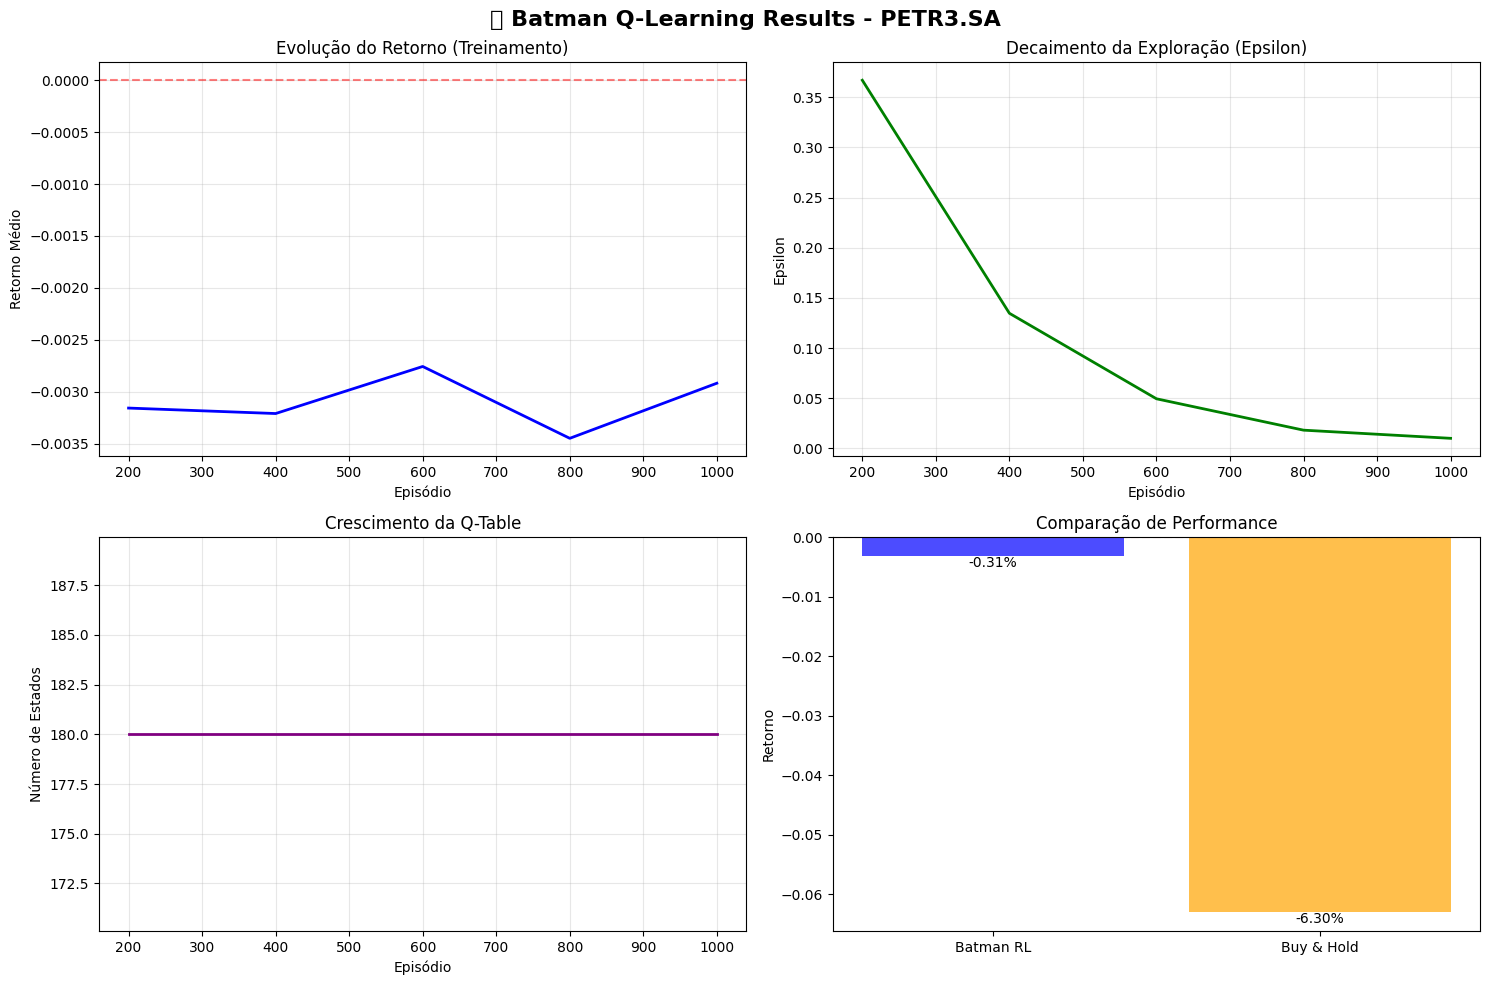

In [17]:
# 📊 Avaliação Completa do Agente Batman
def evaluate_batman_agent(agent, env, num_test_episodes=10):
    """
    Avalia o agente treinado em múltiplos episódios de teste
    """
    print("🧪 Avaliando agente Batman...")
    test_results = []
    
    for test_ep in range(num_test_episodes):
        # Executar episódio de teste (sem exploração)
        state = env.reset()
        episode_actions = []
        episode_rewards = []
        
        while True:
            # Usar apenas exploitação (greedy policy)
            action, _ = agent.get_action(state, training=False)
            episode_actions.append(action)
            
            next_state, reward, done, info = env.step(action)
            episode_rewards.append(reward)
            
            if done:
                break
            state = next_state
        
        # Registrar resultado do teste
        episode_summary = env.get_episode_summary()
        if episode_summary:
            test_results.append({
                'episode': test_ep + 1,
                'final_value': episode_summary['final_value'],
                'total_return': episode_summary['total_return'],
                'total_reward': episode_summary['total_reward'],
                'actions_taken': episode_summary['actions_taken'],
                'num_days': episode_summary['num_days']
            })
    
    # Análise dos resultados
    if test_results:
        avg_return = np.mean([r['total_return'] for r in test_results])
        avg_final_value = np.mean([r['final_value'] for r in test_results])
        avg_actions = np.mean([r['actions_taken'] for r in test_results])
        win_rate = len([r for r in test_results if r['total_return'] > 0]) / len(test_results)
        
        print(f"📈 Resultados da Avaliação Batman ({num_test_episodes} episódios):")
        print(f"   💰 Valor final médio: R$ {avg_final_value:,.2f}")
        print(f"   📊 Retorno médio: {avg_return:+.2%}")
        print(f"   🎯 Taxa de sucesso: {win_rate:.1%}")
        print(f"   🔄 Ações médias por episódio: {avg_actions:.1f}")
        print(f"   📅 Dias de trading: {test_results[0]['num_days']}")
        
        # Comparar com Buy & Hold
        buy_hold_return = (prices[-1] - prices[env.state_manager.window_size]) / prices[env.state_manager.window_size]
        print(f"   📈 Buy & Hold: {buy_hold_return:+.2%}")
        print(f"   🏆 Alpha vs B&H: {avg_return - buy_hold_return:+.2%}")
        
        return {
            'avg_return': avg_return,
            'avg_final_value': avg_final_value,
            'win_rate': win_rate,
            'buy_hold_return': buy_hold_return,
            'alpha': avg_return - buy_hold_return,
            'test_results': test_results
        }
    
    return None

# Criar gráficos de análise
def plot_batman_results(training_history, evaluation_results):
    """
    Cria gráficos de análise dos resultados Batman
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'🦇 Batman Q-Learning Results - {TICKER_SYMBOL}', fontsize=16, fontweight='bold')
    
    # 1. Evolução do treinamento
    axes[0,0].plot(training_history['episode'], training_history['avg_return'], 'b-', linewidth=2)
    axes[0,0].set_title('Evolução do Retorno (Treinamento)')
    axes[0,0].set_xlabel('Episódio')
    axes[0,0].set_ylabel('Retorno Médio')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    
    # 2. Evolução do epsilon
    axes[0,1].plot(training_history['episode'], training_history['epsilon'], 'g-', linewidth=2)
    axes[0,1].set_title('Decaimento da Exploração (Epsilon)')
    axes[0,1].set_xlabel('Episódio')
    axes[0,1].set_ylabel('Epsilon')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Crescimento da Q-table
    axes[1,0].plot(training_history['episode'], training_history['q_table_size'], 'purple', linewidth=2)
    axes[1,0].set_title('Crescimento da Q-Table')
    axes[1,0].set_xlabel('Episódio')
    axes[1,0].set_ylabel('Número de Estados')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Comparação de performance
    if evaluation_results:
        methods = ['Batman RL', 'Buy & Hold']
        returns = [evaluation_results['avg_return'], evaluation_results['buy_hold_return']]
        colors = ['blue', 'orange']
        
        bars = axes[1,1].bar(methods, returns, color=colors, alpha=0.7)
        axes[1,1].set_title('Comparação de Performance')
        axes[1,1].set_ylabel('Retorno')
        axes[1,1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
        
        # Adicionar valores nas barras
        for bar, return_val in zip(bars, returns):
            height = bar.get_height()
            axes[1,1].text(bar.get_x() + bar.get_width()/2., height,
                          f'{return_val:+.2%}',
                          ha='center', va='bottom' if height > 0 else 'top')
    
    plt.tight_layout()
    plt.show()

# Executar avaliação
if df_stock is not None and 'training_history' in locals():
    evaluation_results = evaluate_batman_agent(agent, env, num_test_episodes=20)
    plot_batman_results(training_history, evaluation_results)
else:
    print("⚠️ Execute primeiro o treinamento para avaliar o agente!")

## 🔧 TESTE COM OUTRO ATIVO

Para usar com outro ativo, simplesmente altere a variável `TICKER_SYMBOL` no início do notebook e execute novamente!

In [18]:
# 🔧 Exemplo: Como trocar para outro ativo
"""
Para testar com VALE3, por exemplo:

1. Volte à segunda célula do notebook
2. Altere: TICKER_SYMBOL = "VALE3.SA"  
3. Execute novamente todas as células

O sistema automaticamente:
✅ Baixará os dados da VALE3
✅ Reconfigurará o ambiente
✅ Treinará o agente com os novos dados
✅ Avaliará a performance

Ativos suportados (B3):
- PETR3.SA, PETR4.SA (Petrobras)
- VALE3.SA (Vale)
- BRFS3.SA (BRF)
- ITUB4.SA (Itaú)
- BBAS3.SA (Banco do Brasil)
- ABEV3.SA (Ambev)
- E muitos outros...
"""

print("🔧 Sistema Batman configurado para flexibilidade!")
print(f"📊 Atualmente usando: {TICKER_SYMBOL}")
print("💡 Para trocar o ativo, altere TICKER_SYMBOL e re-execute o notebook!")

# Resumo final do Batman
print("\n" + "="*60)
print("🦇 RESUMO BATMAN Q-LEARNING")
print("="*60)
print("✅ Q-Learning clássico implementado")
print("✅ Estados discretizados para estabilidade") 
print("✅ Tabela Q tradicional")
print("✅ Exploração ε-greedy")
print("✅ Sistema flexível para qualquer ativo")
print("✅ Monitoramento completo de treinamento")
print("✅ Avaliação com benchmarks")
print("✅ Visualizações analíticas")
print("="*60)

🔧 Sistema Batman configurado para flexibilidade!
📊 Atualmente usando: PETR3.SA
💡 Para trocar o ativo, altere TICKER_SYMBOL e re-execute o notebook!

🦇 RESUMO BATMAN Q-LEARNING
✅ Q-Learning clássico implementado
✅ Estados discretizados para estabilidade
✅ Tabela Q tradicional
✅ Exploração ε-greedy
✅ Sistema flexível para qualquer ativo
✅ Monitoramento completo de treinamento
✅ Avaliação com benchmarks
✅ Visualizações analíticas


# 🦇 BATMAN APPROACH - Reinforcement Learning Trading

## Estratégia: Metodológica e Estruturada

### Filosofia Batman
- **Preparação meticulosa**: Base teórica sólida seguindo padrões acadêmicos
- **Abordagem conservadora**: Q-Learning clássico com tabelas Q
- **Metodologia comprovada**: Seguindo estrutura similar às aulas do Prof. Paulo Caixeta
- **Estados discretizados**: Preços convertidos em faixas para simplicidade
- **Foco pedagógico**: Prioriza entendimento dos fundamentos de RL

### Objetivo
Desenvolver um agente de Reinforcement Learning para trading automatizado usando **Q-Learning tradicional**.
O sistema deve ser **genérico** e funcionar com qualquer ativo (PETR3, VALE3, BRFS3, etc.).

### Características da Implementação
- ✅ Q-Learning clássico com tabela Q
- ✅ Estados discretos (faixas de preços)
- ✅ Exploração ε-greedy
- ✅ Ambiente compatível com padrões Gymnasium
- ✅ Código flexível para múltiplos ativos
- ✅ Fundamentação teórica clara